In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
from scipy import signal, stats, io
import numpy as np
import sys
sys.path.append('..')
import glob
from neurolib.utils import functions
from neurolib.models.wc import WCModel
import neurolib.utils.loadData as ld
import neurolib.utils.functions as func
from task_fc_simulation.read_utils import read_onsets_from_input, read_generate_task_matrices
from task_fc_simulation.onset_design_model import WCOnsetDesign, HRF
from task_fc_simulation.cole2019model import NeuralMassModel
from task_fc_simulation.weight_matrix_utils import normalize, generate_modulars
%load_ext autoreload
%autoreload 2
plt.rcParams['image.cmap'] = 'plasma'

## WC model with single neuronal population

In [2]:
wc = WCModel()
wc.params['duration'] = 2.0*1000

In [3]:
max_exc = []
min_exc = []

exc_inputs = np.linspace(0, 3.5, 50)
for exc_ext in exc_inputs:

    wc.params['exc_ext'] = exc_ext
    wc.run()

    max_exc.append(np.max(wc.exc[0, -int(1000/wc.params['dt']):]))
    min_exc.append(np.min(wc.exc[0, -int(1000/wc.params['dt']):]))

Text(0, 0.5, 'Min / max act')

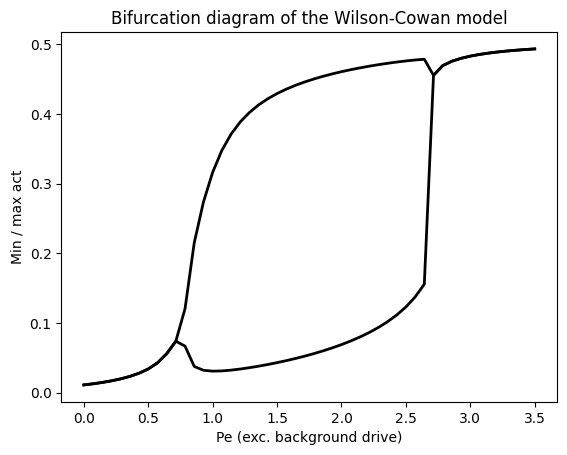

In [4]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Pe (exc. background drive)")
plt.ylabel("Min / max act")

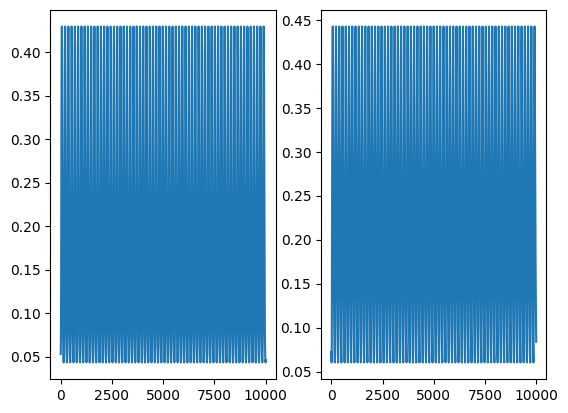

In [5]:
exc_ext = 1.5
wc.params['exc_ext'] = exc_ext
wc.run()
plt.subplot(1,2,1); plt.plot(wc.exc[0, -int(1000/wc.params['dt']):]);
plt.subplot(1,2,2);plt.plot(wc.inh[0, -int(1000/wc.params['dt']):]);

## Large-scale WC model with our settings and zero background (OU) noise


In [6]:
wc_params = {'exc_ext': 0.758, # excitatory background drive
             'K_gl': 2.63, # global coupling parameter
             'sigma_ou': 0, # std of the Ornstein-Uhlenbeck noise
             'inh_ext': 0, # inhibitory background drive
             'tau_ou': 5, # [ms] timescale of the Ornstein-Uhlenbeck noise
             'a_exc': 1.5, # slope of excitatory response function
             'a_inh': 1.5, # slope of inhibitory response function
             'c_excexc': 16, # E-to-E synaptic weight
             'c_excinh': 15, # E-to-I synaptic weight
             'c_inhexc': 12, # I-to-E synaptic weight
             'c_inhinh': 3, # I-to-I synaptic weight
             'mu_exc': 3,  # position of maximum slope of excitatory response function
             'mu_inh': 3,  # Position of maximum slope of inhibitory response function
             'tau_exc': 2.5, # excitatory time constant
             'tau_inh': 3.75, # inhibitory time constant
             'signalV': 10 # signal transmission speed between areas [m/s]
            }
sim_parameters = {"delay": 250,"rest_before":True, "first_duration": 6, "last_duration": 6}
TR = 2
a_s_rate = 5*1e-3 # downsampled time step, original integration equal to 0.1 ms or 0.0001s
activity = False

bw_params = {"rho": 0.34, "alpha": 0.32, "V0": 0.02, "k1_mul": None,
                     "k2": None, "k3_mul": None, "gamma": 0.41, "k": 0.65, "tau": 0.98}

In [7]:
SMALL = True
mat_path = '../task_designs/01_BLOCK_[2s_TR]_[20s_DUR]_[10_BLOCKS].mat'
input_data = io.loadmat(mat_path)
if SMALL:
    small_input_data = input_data.copy()
    small_input_data['onsets'][0,0] = input_data['onsets'][0,0][:2]
    small_input_data['onsets'][0,1] = input_data['onsets'][0,1][:2]
    small_mat_path = os.path.join(os.path.dirname(mat_path),'small_'+os.path.basename(mat_path))
    io.savemat(small_mat_path, small_input_data)
    mat_path = small_mat_path
print(f"In the simulation {os.path.basename(mat_path)} will be used")  

In the simulation small_01_BLOCK_[2s_TR]_[20s_DUR]_[10_BLOCKS].mat will be used


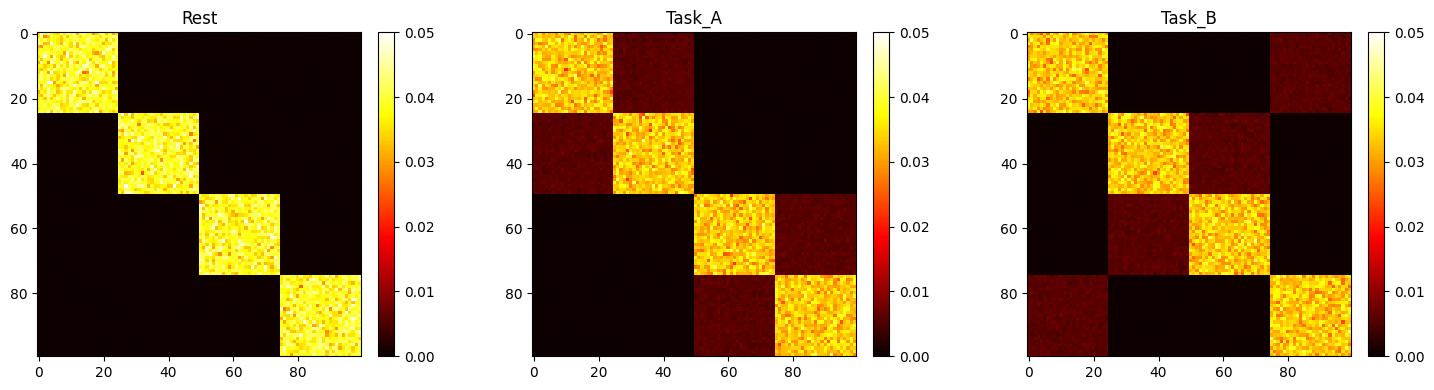

In [8]:
N_ROIs = 100 # number of brain regions
SIGMA = 0.1 # standard deviation of Gaussian distribution for synaptic weights generation
NORM_TYPE = "cols" # normalize by columns (all inputs to each region summed to one)
NUM_MODULES = 4 # number of functional modules 
GEN_TYPE = 'simple_prod' # generation type, simple_prod or equal_var

C_rest, C_task_dict = read_generate_task_matrices(mat_path, N_ROIs, num_modules=NUM_MODULES,
                                sigma=SIGMA, norm_type=NORM_TYPE)
C_task_list = list(C_task_dict.values())
C_list = [C_rest]+C_task_list
title_list =['Rest']+ list(C_task_dict.keys())
fig, axs = plt.subplots(1, 3, figsize = (15,4))

#list of possible colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
for i in [0,1,2]:
    im = axs[i].imshow(C_list[i], cmap='hot', vmin = 0, vmax=0.05); axs[i].set_title(title_list[i]);
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()

In [9]:
%%time
#path to mat file with the predefined structure with onsets and synaptic weights matrices parameters
wc_block = WCOnsetDesign.from_matlab_structure(mat_path, sigma=SIGMA, norm_type=NORM_TYPE, num_modules=NUM_MODULES, 
                                               num_regions= N_ROIs, **wc_params, **sim_parameters)
wc_block.generate_full_series(TR=TR, activity=activity, a_s_rate=a_s_rate, clear_raw=False,
                              normalize_max=1.01, output_activation='syn_act', **bw_params)

Wall time: 40.6 s


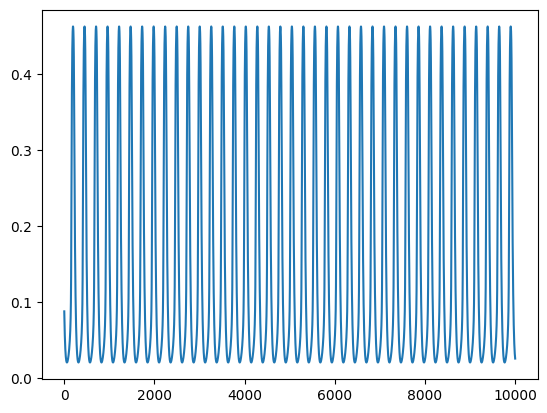

In [10]:
plt.plot(wc_block.wc.exc[0, -int(1000/wc.params['dt']):]);

In [11]:
max_exc = []
min_exc = []

exc_inputs = np.linspace(0, 3, 30)
for exc_ext in tqdm(exc_inputs):

    wc_params['exc_ext'] = exc_ext
    
    wc_block = WCOnsetDesign.from_matlab_structure(mat_path, sigma=SIGMA, norm_type=NORM_TYPE, num_modules=NUM_MODULES, 
                                               num_regions= N_ROIs, **wc_params, **sim_parameters)
    
    wc_block.generate_full_series(TR=TR, activity=activity, a_s_rate=a_s_rate, clear_raw=False,
                              normalize_max=1.01, output_activation='syn_act', **bw_params)
    
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_exc.append(np.max(wc_block.wc.exc[0, -int(1000/wc.params['dt']):]))
    min_exc.append(np.min(wc_block.wc.exc[0, -int(1000/wc.params['dt']):]))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [19:23<00:00, 38.80s/it]


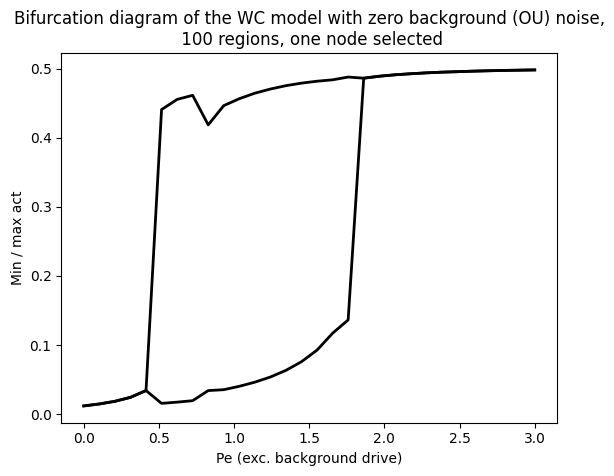

In [12]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title(f"Bifurcation diagram of the WC model with zero background (OU) noise,\n {N_ROIs} regions, one node selected")
plt.xlabel("Pe (exc. background drive)");
plt.ylabel("Min / max act");
bif_dict = {"wc": np.array([exc_inputs, max_exc, min_exc])}

## Cole (2019) model replication

$$\tau_{E} \dot{E_i} = - E_i + f_{E}(c_{EE}*E_i+K_{gl}\sum_{j\neq i} C_{ij}E_{j}+PE_i) + OU_{i}$$


$$\tau_{E} \dot{E_i}  = \tau_{E}\frac{E_i(t+1)-E_i(t)}{dt} = -E_i(t)+\ldots$$

if $\tau_{E}/{dt}=1$, $E_i(t+1)-E_i(t) = -E_i(t)+\ldots$
$$E_i(t+1) = f_{E}(K_{gl}\sum_j C_{ij}E_{j}+PE_i) + OU_{i}$$

For Cole:

 - $I_i(t) = \sum_jGw_{ij}u_j(t-1)+d_i+stim$
 - $u_i(t)=f(I_i+bias)$
 
 $$I_i(t) = \sum_jGw_{ij}f(I_j(t-1)+bias)+d_i+stim$$

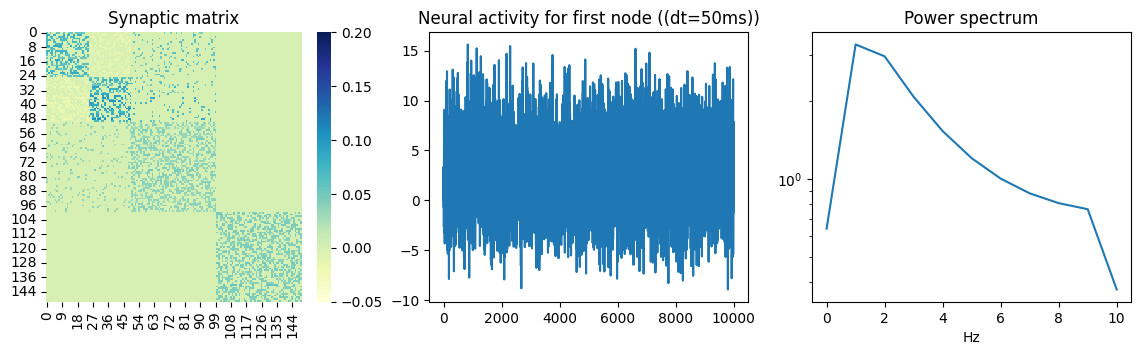

In [13]:
nms = NeuralMassModel(150, num_modules=3)
nms._init_synpatic_cole()
# we took from original code: https://github.com/ColeLab/TaskFCRemoveMeanActivity/blob/master/neuralmassmodel/NeuralMassModel.ipynb
bias_param = -5
indep = 5
g = 5
spont_act_level = 3
output = nms.compute_network_model_cole(10000, bias_param=bias_param,
                                                spont_act_level=spont_act_level, g=g, indep=indep)
fig, axs = plt.subplots(1,3,figsize=(14, 3.5))

sns.heatmap(nms.synaptic_weight, annot=False, vmin=-0.05, vmax=0.2, ax=axs[0], cmap="YlGnBu")
axs[0].set_title("Synaptic matrix")
axs[1].plot(output['input_activity'][:,0])
axs[1].set_title('Neural activity for first node ((dt=50ms))');
maxfr = 50
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(output['input_activity'].T, 50, spectrum_windowsize=1, maxfr=maxfr)
axs[2].semilogy(f,  Pxx_Welsh); axs[2].set_title('Power spectrum', fontsize=12);
axs[2].set_xlabel("Hz");

In [14]:
results_dict = {"syn_matrix": nms.synaptic_weight, "act": output['input_activity'][:,0], "PowerDensity": np.array([f, Pxx_Welsh]), }
#io.savemat(resmatfile, {**results_dict, **setting_dict})

## Bifurcation diagram for the Cole (2019) model with zero noise

In [15]:
#output['input_activity'][-1000:,0]

In [16]:
max_exc = []
min_exc = []

bias_params = np.linspace(-7, 0, 30)
indep = 5
g = 5
spont_act_level = 0
for bias_param in tqdm(bias_params):

    output = nms.compute_network_model_cole(10000, bias_param=bias_param,
                                                spont_act_level=spont_act_level, g=g, indep=indep)

    max_exc.append(np.max(output['input_activity'][-1000:,0]))
    min_exc.append(np.min(output['input_activity'][-1000:,0]))
bif_dict["Cole"] = np.array([bias_params, max_exc, min_exc])

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.33it/s]


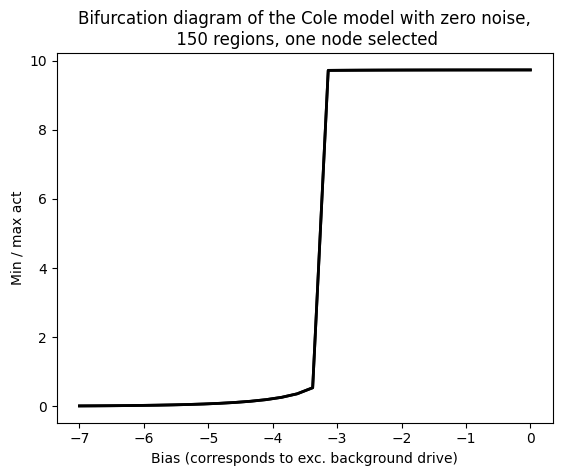

In [17]:
plt.plot(bias_params, max_exc, c='k', lw = 2)
plt.plot(bias_params, min_exc, c='k', lw = 2)
plt.title(f"Bifurcation diagram of the Cole model with zero noise,\n 150 regions, one node selected")
plt.xlabel("Bias (corresponds to exc. background drive)");
plt.ylabel("Min / max act");

In [19]:
resmatfile = '../ResultCole.mat'
io.savemat(resmatfile, {**bif_dict, **results_dict})